In [1]:
import torch, os
import copy
import time
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from masked_celeba import CelebA
from models.BasicAutoEncoder import BasicAE
from models.BasicAutoEncoderII import BasicAEII

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# access celebA
data_root = 'data'
# Spatial size of training images, images are resized to this size.
image_size = 28

celeba_train = CelebA(data_root,
                              download=False,
                              split = "train",
                              transform=transforms.Compose([
                                  transforms.Grayscale(),
                                  transforms.Resize(image_size),
                                  transforms.CenterCrop(image_size),
                                  transforms.ToTensor(),
                              ]),
                              proportion = 0.3)

celeba_test = CelebA(data_root,
                              download=False,
                              split = "test",
                              transform=transforms.Compose([
                                  transforms.Grayscale(),
                                  transforms.Resize(image_size),
                                  transforms.CenterCrop(image_size),
                                  transforms.ToTensor(),
                              ]),
                              proportion = 0.3) 

In [4]:
# Create training and test dataloaders

num_workers = 4
# how many samples per batch to load
batch_size = 2

NUM_SAMP = 32

# use random sampler to decrease training and testing time
rand_sampler_train = torch.utils.data.RandomSampler(celeba_train, num_samples= NUM_SAMP, replacement=True)
rand_sampler_test = torch.utils.data.RandomSampler(celeba_test, num_samples=NUM_SAMP, replacement=True)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(celeba_train, batch_size=batch_size, num_workers=num_workers, sampler=rand_sampler_train)
val_loader = torch.utils.data.DataLoader(celeba_test, batch_size=batch_size, num_workers=num_workers, sampler = rand_sampler_test)

dataloaders = {"train": train_loader,
                   "val": val_loader}

In [18]:
# display a couple of the test images and generated masks
for i in range(1,3):
    celeba_train.display(i)


AttributeError: 'CelebA' object has no attribute '_CelebA__getitem'

In [6]:
def dice_coef(y_true, y_pred):
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (torch.sum(y_true_f + y_pred_f))


In [14]:
# initialize model
model = BasicAEII()
# model.load_state_dict(torch.load('baeii_200.pt')) # optionally load weights
model.to(device)


BasicAEII(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [8]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
def train_model(model, criterion, optimizer, scheduler, dataloaders,
                device, track_out, num_epochs=8):
    """

    :param model: initialized model to train
    :param criterion: loss function
    :param dataloaders: dictionary of dataloaders for training and validation
    :param device: CPU or GPU to train on
    :param track_out: whether or not to track the running accuracy and loss (for later plotting)
    :param num_epochs:
    :return: model, optimizer, best accuracy, best loss (optionally also running training/validation
    los and accuracy)
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_optim = copy.deepcopy(optimizer.state_dict())
    best_acc = 0.0
    best_loss = float("inf")

    if track_out:
        train_loss = []
        train_acc = []

        val_loss = []
        val_acc = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for image, mask in dataloaders[phase]:
                # change this!
                # this is currenlty needed to reshape images into input for BasicAE,
                # but ideally I would just change the model architecture
                # image = image.reshape(-1, 28*28)
                # mask = mask.reshape(-1, 28*28)

                image = image.to(device)
                mask = mask.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(mask)
                    loss = criterion(outputs, image)

                    # propagate loss and step optimizer if in training stage
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # get loss
                running_loss += loss.item() * image.size(0)
                # change to DICE
                # running_corrects += torch.sum(preds == labels.data)

            # update the learning rate if this is training iteration
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / NUM_SAMP
            # epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if track_out:
                if phase == "train":
                    train_loss.append(epoch_loss.detach().cpu().squeeze())
                    # train_acc.append(epoch_acc.detach().cpu().squeeze())

                else:
                    val_loss.append(epoch_loss.detach().cpu().squeeze())
                    # val_acc.append(epoch_acc.detach().cpu().squeeze())

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # save model if accuracy has improved
            if phase == 'val' and epoch_loss < best_loss:
                # best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_optim = copy.deepcopy(optimizer.state_dict())
                best_loss = epoch_loss

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    optimizer.load_state_dict(best_optim)

    if track_out:
        return model, optimizer, best_acc, best_loss, train_acc, train_loss, val_acc, val_loss

    return model, optimizer, best_acc, best_loss

In [15]:
# train model

model_ft, optimizer_ft, accuracy, loss = train_model(model,
                                                         criterion,
                                                         optimizer,
                                                         exp_lr_scheduler,
                                                         dataloaders,
                                                         device,
                                                         track_out= False,
                                                         num_epochs=100)

Epoch 0/99
----------
train Loss: 0.0224
val Loss: 0.0214
Epoch 1/99
----------
train Loss: 0.0198
val Loss: 0.0280
Epoch 2/99
----------
train Loss: 0.0208
val Loss: 0.0240
Epoch 3/99
----------
train Loss: 0.0177
val Loss: 0.0172
Epoch 4/99
----------
train Loss: 0.0200
val Loss: 0.0240
Epoch 5/99
----------
train Loss: 0.0200
val Loss: 0.0191
Epoch 6/99
----------
train Loss: 0.0217
val Loss: 0.0207
Epoch 7/99
----------
train Loss: 0.0195
val Loss: 0.0194
Epoch 8/99
----------
train Loss: 0.0202
val Loss: 0.0241
Epoch 9/99
----------
train Loss: 0.0208
val Loss: 0.0208
Epoch 10/99
----------
train Loss: 0.0212
val Loss: 0.0225
Epoch 11/99
----------
train Loss: 0.0208
val Loss: 0.0200
Epoch 12/99
----------
train Loss: 0.0208
val Loss: 0.0202
Epoch 13/99
----------
train Loss: 0.0193
val Loss: 0.0217
Epoch 14/99
----------
train Loss: 0.0224
val Loss: 0.0217
Epoch 15/99
----------
train Loss: 0.0262
val Loss: 0.0233
Epoch 16/99
----------
train Loss: 0.0221
val Loss: 0.0215
Epoch 1

In [11]:
def show_validation(validation_loader, max):

    dataiter = iter(validation_loader)
    images, masks = next(dataiter)

    # masks = masks.reshape(-1, 28*28)

    # get sample outputs
    masks = masks.to(device)
    torch.set_grad_enabled(False)
    output = model(masks)

    # prep images for display
    masks = masks.cpu().numpy()
    # masks = masks.cpu().numpy().reshape(-1, 28, 28)



    # output is resized into a batch of images
    # output = output.cpu().numpy().reshape(-1, 28, 28)
    output = output.cpu().numpy()

    count = 0

    for out, m in zip(output, masks):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title('Mask')
        ax1.imshow(m[0])
        ax2.set_title('Transformed Image')
        ax2.imshow(out[0])

        count += 1
        if count == max:
            break

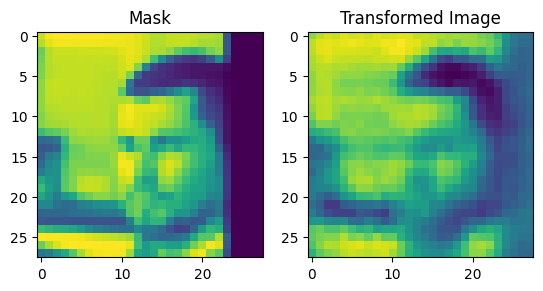

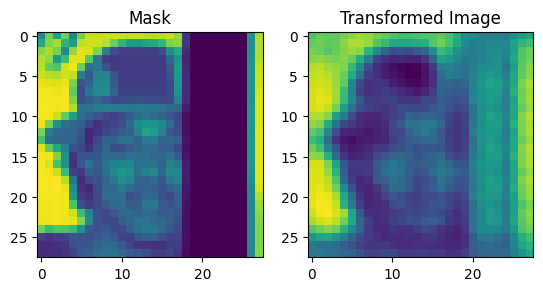

In [19]:
show_validation(val_loader, 2)